# Tensorflow 설치 확인

In [92]:
import tensorflow as tf
tf.__version__

'2.16.1'

# 라이브러리 추가

In [93]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re # 정규화(특수문자 걸러냄)
from konlpy.tag import Okt # tag : 단어 품사 확인
from tqdm import tqdm # 네이버 영화 리뷰 데이터 가져올 때 사용
from tensorflow.keras.preprocessing.text import Tokenizer # 텍스트 tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences # 벡터 처리

# 클라우드에 있는 DATASET을 파일로 받는 방법

In [94]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")

('ratings_train.txt', <http.client.HTTPMessage at 0x18666eb76e0>)

In [95]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x18666eb7800>)

# Pandas를 사용하여 데이터 불러오기

In [96]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

# 데이터셋 확인

In [97]:
print("훈련 샘플의 개수 : ", len(train_data)) # 훈련용 리뷰 개수 출력
print("테스트 샘플의 개수 : ", len(test_data)) # 테스트용 리뷰 개수 출력

훈련 샘플의 개수 :  150000
테스트 샘플의 개수 :  50000


In [98]:
# Pandas에서 데이터 확인
train_data # Label은 긍/부정 의미

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


# 데이터 중복 확인(유일값 찾기)

In [99]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

# 중복된 데이터 제거

In [100]:
# 총 샘플 수
train_data.drop_duplicates(subset=['document'], inplace=True)
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


#  데이터 시각화(Matplotlib)

<Axes: xlabel='label'>

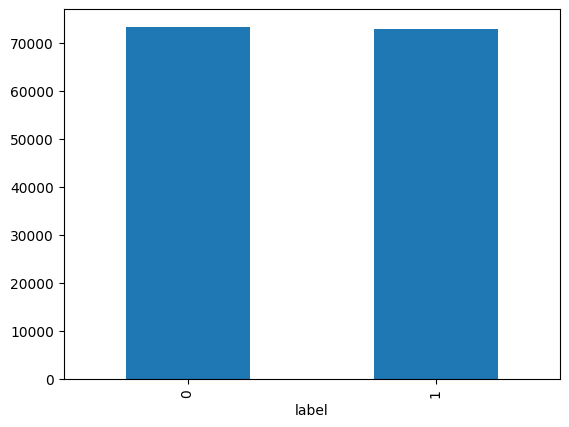

In [101]:
train_data['label'].value_counts().plot(kind = 'bar')

In [102]:
# 그룹으로 분석
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


# Null 값 존재 여부 판단

In [103]:
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

# 공백 제거

In [104]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [105]:
train_data = train_data.dropna(how = 'any')
train_data.isnull().values.any()
len(train_data)

146182

In [106]:
# 한글, 공백을 제외한 모든 단어(특수문자) 제거
train_data.loc[:, 'document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
# train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [107]:
train_data['document']

0                                         아 더빙 진짜 짜증나네요 목소리
1                                흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                                 교도소 이야기구먼 솔직히 재미는 없다평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
                                ...                        
149995                                      인간이 문제지 소는 뭔죄인가
149996                                           평점이 너무 낮아서
149997                        이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다
149998                           청춘 영화의 최고봉방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 146182, dtype: object

In [112]:
train_data.loc[:, 'document'] = train_data['document'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
train_data.loc[train_data['document'] == '', 'document'] = np.nan
print(train_data.isnull().sum())

# train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
# train_data['document'].replace('', np.nan, inplace=True)
# print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


In [113]:
train_data

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
...,...,...,...
149995,6222902,인간이 문제지 소는 뭔죄인가,0
149996,8549745,평점이 너무 낮아서,1
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
149998,2376369,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1


In [114]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [115]:
train_data = train_data.dropna(how = 'any')

In [119]:
# document 열에서 중복인 내용이 있다면 중복 제거
test_data.drop_duplicates(subset=['document'], inplace=True)

# 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)

# 공백을 empty 값으로 변경
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True)

# 공백을 Null 값으로 변경
test_data.loc[test_data['document'] == '', 'document'] = np.nan

# Null 값 제거
test_data = test_data.dropna(how='any')

In [ ]:
test_data

In [120]:
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48389


In [122]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [123]:
okt = Okt()

In [124]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145393/145393 [07:28<00:00, 324.50it/s]


In [125]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48389/48389 [02:58<00:00, 270.92it/s]


In [129]:
print('전처리 후 테스트용 샘플의 개수 :',len(X_test))

전처리 후 테스트용 샘플의 개수 : 48389


In [130]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [131]:
print(tokenizer.word_counts.items())

odict_items([('아', 4138), ('더빙', 573), ('진짜', 8312), ('짜증나다', 1010), ('목소리', 374), ('흠', 251), ('포스터', 572), ('보고', 4658), ('초딩', 422), ('영화', 50367), ('줄', 1241), ('오버', 142), ('연기', 6326), ('조차', 242), ('가볍다', 361), ('않다', 7722), ('너', 670), ('무재', 69), ('밓었', 1), ('다그', 75), ('래서', 20), ('보다', 41072), ('추천', 1183), ('다', 10105), ('교도소', 16), ('이야기', 2171), ('구먼', 11), ('솔직하다', 1203), ('재미', 3879), ('없다', 15572), ('평점', 6266), ('조정', 40), ('사이', 222), ('몬페', 2), ('그', 5670), ('익살스럽다', 9), ('돋보이다', 288), ('스파이더맨', 64), ('에서', 6981), ('늙다', 198), ('보이다', 1074), ('커스틴', 4), ('던스트', 2), ('너무나도', 206), ('이쁘다', 1034), ('막', 333), ('걸음', 20), ('마', 236), ('떼다', 151), ('세', 599), ('부터', 1717), ('초등학교', 116), ('학년', 121), ('생인', 6), ('살다', 1173), ('ㅋㅋㅋ', 2448), ('별', 1928), ('반개', 205), ('아깝다', 4419), ('움', 1053), ('원작', 1253), ('긴장감', 832), ('을', 23208), ('제대로', 796), ('살리다', 534), ('욕', 779), ('나오다', 6397), ('이응경', 8), ('길용우', 4), ('연', 882), ('기', 1974), ('생활', 126), ('몇', 697), ('년', 1991

In [132]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [133]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


In [134]:
tokenizer = Tokenizer(vocab_size) # 빈도수 2 이하인 단어는 제거
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [135]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [136]:
print(len(X_train))
print(len(y_train))

145393
145393


In [137]:
print(X_train[:3])

[[50, 454, 16, 260, 659], [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19], [386, 2444, 2315, 5671, 2, 222, 9]]


In [138]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [139]:
print(drop_train)

[28, 414, 1149, 1347, 1572, 1711, 2321, 2345, 2432, 3440, 4289, 4612, 4809, 5021, 5722, 7141, 7790, 9660, 10596, 10973, 11669, 12722, 12766, 12896, 13788, 15427, 16782, 18597, 18626, 19286, 21297, 24351, 24583, 24871, 25031, 25860, 26313, 27110, 27497, 28474, 28600, 28938, 29596, 29618, 30187, 30623, 32218, 32462, 32874, 32885, 33701, 34017, 34216, 34919, 36295, 37099, 37481, 39648, 40010, 40364, 40665, 43207, 43312, 43410, 43838, 43922, 43984, 44094, 44629, 45388, 46359, 46788, 46909, 47456, 47865, 48205, 48827, 51094, 52043, 52778, 52980, 53565, 54640, 54875, 55519, 56274, 56971, 57036, 57277, 57391, 60421, 60439, 60718, 61783, 61949, 62106, 62592, 63085, 63487, 63632, 64232, 64332, 65184, 65481, 66049, 66665, 67697, 67928, 68049, 69478, 70138, 70510, 71315, 72129, 73255, 74008, 74186, 75521, 75921, 77418, 77739, 78027, 78051, 78416, 78887, 79170, 79754, 80550, 80662, 81848, 82858, 84521, 84990, 87275, 87381, 87490, 87497, 88069, 88706, 89022, 89292, 90566, 91144, 92800, 93043, 93533

In [140]:
len(drop_train)

231

In [141]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# drop_train 배열 형식 변환 및 1차원 확인
drop_train = np.array(drop_train)
if drop_train.ndim != 1:
    raise ValueError("drop_train 배열은 1차원이어야 합니다.")

# X_train, y_train 형식 확인 및 변환
if not isinstance(y_train, np.ndarray):
    y_train = np.array(y_train)

# 패딩 적용
X_train_padded = pad_sequences(X_train, padding='post')

# 인덱스 값 범위 확인
if np.any(drop_train >= len(X_train_padded)):
    raise ValueError("drop_train에 유효하지 않은 인덱스 값이 포함되어 있습니다.")

# drop_train 인덱스 제거
X_train_padded = np.delete(X_train_padded, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

# 최종 결과 출력
print('drop_train 인덱스를 제거한 후 X_train_padded의 shape:', X_train_padded.shape)
print('drop_train 인덱스를 제거한 후 y_train의 shape:', y_train.shape)

drop_train 인덱스를 제거한 후 X_train_padded의 shape: (145162, 69)
drop_train 인덱스를 제거한 후 y_train의 shape: (145162,)


In [142]:
print(len(X_train))
print(len(y_train))

145393
145162


In [143]:
print(len(X_test))
print(len(y_test))

48389
48389


In [145]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# drop_test 배열 형식 변환 및 1차원 확인
drop_test = np.array(drop_test)
if drop_test.ndim != 1:
    raise ValueError("drop_test 배열은 1차원이어야 합니다.")

# X_test, y_test 형식 확인 및 변환
if not isinstance(y_test, np.ndarray):
    y_test = np.array(y_test)

# 패딩 적용
X_test_padded = pad_sequences(X_test, padding='post')

# 인덱스 값 범위 확인
if np.any(drop_test >= len(X_test_padded)):
    raise ValueError("drop_test에 유효하지 않은 인덱스 값이 포함되어 있습니다.")

# drop_test 인덱스 제거
X_test_padded = np.delete(X_test_padded, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)

# 최종 결과 출력
print('drop_test 인덱스를 제거한 후 X_test_padded의 shape:', X_test_padded.shape)
print('drop_test 인덱스를 제거한 후 y_test의 shape:', y_test.shape)

drop_test 인덱스를 제거한 후 X_test_padded의 shape: (48282, 60)
drop_test 인덱스를 제거한 후 y_test의 shape: (48282,)


In [146]:
print(len(X_test))
print(len(y_test))

48389
48282


리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.795306514068765


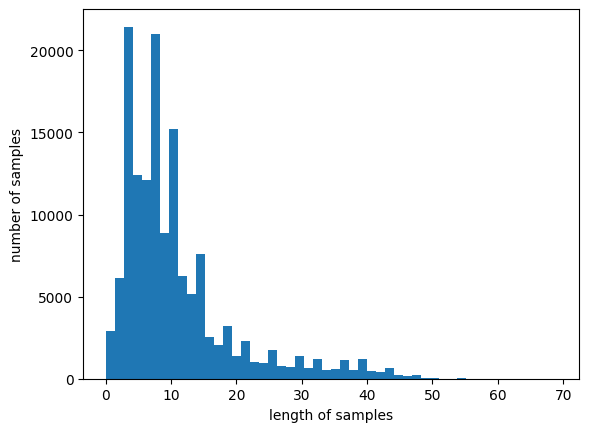

In [147]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [148]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [149]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.32847523608426


In [150]:
# 전체 데이터의 길이는 30으로 맞춘다.
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 2. LSTM으로 네이버 영화 리뷰 감성 분류하기

In [153]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [155]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [156]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [158]:
import numpy as np

# X_train과 y_train의 길이를 확인합니다.
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

# 두 배열의 최소 길이로 자릅니다.
min_length = min(len(X_train), len(y_train))
X_train = X_train[:min_length]
y_train = y_train[:min_length]

print('After trimming:')
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

# 모델 컴파일 및 학습
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

X_train shape: (145393, 30)
y_train shape: (145162,)
After trimming:
X_train shape: (145162, 30)
y_train shape: (145162,)
Epoch 1/15
1814/1815 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.5113 - loss: 0.6928
Epoch 1: val_acc improved from -inf to 0.49943, saving model to best_model.keras
1815/1815 ━━━━━━━━━━━━━━━━━━━━ 52s 28ms/step - acc: 0.5113 - loss: 0.6928 - val_acc: 0.4994 - val_loss: 0.6933
Epoch 2/15
1815/1815 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc: 0.5275 - loss: 0.6915
Epoch 2: val_acc improved from 0.49943 to 0.50491, saving model to best_model.keras
1815/1815 ━━━━━━━━━━━━━━━━━━━━ 53s 29ms/step - acc: 0.5275 - loss: 0.6915 - val_acc: 0.5049 - val_loss: 0.6939
Epoch 3/15
1815/1815 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.5401 - loss: 0.6884
Epoch 3: val_acc did not improve from 0.50491
1815/1815 ━━━━━━━━━━━━━━━━━━━━ 47s 26ms/step - acc: 0.5401 - loss: 0.6884 - val_acc: 0.5026 - val_loss: 0.6967
Epoch 4/15
1813/1815 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.5635 - loss: 0.681

In [160]:
# X_test와 y_test의 길이를 확인합니다.
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

# 두 배열의 최소 길이로 자릅니다.
min_length = min(len(X_test), len(y_test))
X_test = X_test[:min_length]
y_test = y_test[:min_length]

print('After trimming:')
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

# 모델 평가
accuracy = model.evaluate(X_test, y_test)[1]
print("\n 테스트 정확도: %.4f" % accuracy)

# print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

X_test shape: (48389, 30)
y_test shape: (48282,)
After trimming:
X_test shape: (48282, 30)
y_test shape: (48282,)
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - acc: 0.5049 - loss: 0.7041

 테스트 정확도: 0.5036


In [ ]:
model.save('best_model_1.h5')model.save('best_model.h5')